In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import pandas as pd
from sklearn import svm, metrics, model_selection

# Extraction of the data

In [2]:
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
daily='csse_covid_19_daily_reports/' #+date in the form  01-22-2020.csv
time_serie='csse_covid_19_time_series/' #+confirmed, death,recovered
confirmed_data='time_series_covid19_confirmed_global.csv'
death_data='time_series_covid19_deaths_global.csv'
recovered_data='time_series_covid19_recovered_global.csv'

In [3]:
confirmed=pd.read_csv(url+time_serie+confirmed_data)
dead=pd.read_csv(url+time_serie+death_data)
recovered=pd.read_csv(url+time_serie+recovered_data)

In [68]:
def date(day,month):   #convert a date in (day,month) format to a string to feed in the read_csv function
    day=str(day)
    month=str(month)
    if len(day)==1:
        day='0'+day
    if len(month)==1:
        month='0'+month 
    date=month+'-'+day+'-2020'
    return date

In [51]:
today=pd.read_csv(url+daily+date(28,3)+'.csv')
today.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-03-28 23:05:37,34.223334,-82.461707,3,0,0,0,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-03-28 23:05:37,30.295065,-92.414197,9,1,0,0,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-03-28 23:05:37,37.767072,-75.632346,2,0,0,0,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-03-28 23:05:37,43.452658,-116.241552,76,0,0,0,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-03-28 23:05:37,41.330756,-94.471059,1,0,0,0,"Adair, Iowa, US"


In [70]:
#This cell save the data for the us in a dictionary us_data. Pay attention to adjuste to if statement to
#adjust it at the current date. The value of the dict are dataframe with: first ligne:confirme case, second: dead, 
#third: recovered. the columns are the different dates
us_data={}
total_state=[]
for month in range(1,4):
    for day in range(1,32):
        if month==1 and day<23:
            pass
        elif month==2 and day>29:
            pass
        elif month==4:
            pass
        elif month==3 and day==31:
            pass
        else:
            dat=date(day,month)
            print(dat)
            today=pd.read_csv(url+daily+dat+'.csv')
            if month<3 or (month==3 and day<22):
                st='Province/State'
                country='Country/Region'
            else:
                st='Province_State'
                country='Country_Region'
            for i, state in enumerate(today[st]):
                if today[country].iloc[i]!='US':
                    pass
                else:
                    if state not in total_state:
                        us_data[state]=pd.DataFrame()
                        us_data[state][dat]=np.array([today['Confirmed'].iloc[i],today['Deaths'].iloc[i],today['Recovered'].iloc[i]])
                    elif dat not in us_data[state].columns:
                        us_data[state][dat]=np.array([today['Confirmed'].iloc[i],today['Deaths'].iloc[i],today['Recovered'].iloc[i]])
                    else:
                        us_data[state][dat]+=np.array([today['Confirmed'].iloc[i],today['Deaths'].iloc[i],today['Recovered'].iloc[i]])
                        
                    total_state.append(state)
  

01-23-2020
01-24-2020
01-25-2020
01-26-2020
01-27-2020
01-28-2020
01-29-2020
01-30-2020
01-31-2020
02-01-2020
02-02-2020
02-03-2020
02-04-2020
02-05-2020
02-06-2020
02-07-2020
02-08-2020
02-09-2020
02-10-2020
02-11-2020
02-12-2020
02-13-2020
02-14-2020
02-15-2020
02-16-2020
02-17-2020
02-18-2020
02-19-2020
02-20-2020
02-21-2020
02-22-2020
02-23-2020
02-24-2020
02-25-2020
02-26-2020
02-27-2020
02-28-2020
02-29-2020
03-01-2020
03-02-2020
03-03-2020
03-04-2020
03-05-2020
03-06-2020
03-07-2020
03-08-2020
03-09-2020
03-10-2020
03-11-2020
03-12-2020
03-13-2020
03-14-2020
03-15-2020
03-16-2020
03-17-2020
03-18-2020
03-19-2020
03-20-2020
03-21-2020
03-22-2020
03-23-2020
03-24-2020
03-25-2020
03-26-2020
03-27-2020
03-28-2020
03-29-2020
03-30-2020


In [71]:
us_data['Iowa']

,03-10-2020,03-11-2020,03-12-2020,03-13-2020,03-14-2020,03-15-2020,03-16-2020,03-17-2020,03-18-2020,03-19-2020,...,03-21-2020,03-22-2020,03-23-2020,03-24-2020,03-25-2020,03-26-2020,03-27-2020,03-28-2020,03-29-2020,03-30-2020
0,8,13,16,17,17,18,23,23,29,44,...,68,90,105,124,146,179,235,298,336,424
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,3,3,4,6
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Exploration

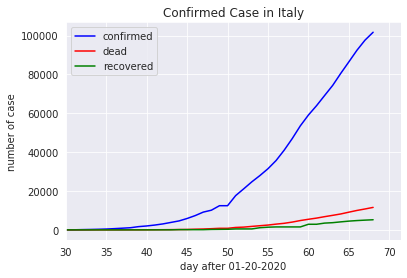

In [73]:
confirmed_italy=confirmed.iloc[137,4:]
dead_italy=dead.iloc[137,4:]
recovered_italy=recovered.iloc[137,4:]
confirmed_italy
time=np.arange(len(confirmed_italy))
plt.figure()
plt.title('Confirmed Case in Italy')
plt.xlabel('day after 01-20-2020')
plt.ylabel('number of case')
plt.plot(time,confirmed_italy,'b-',label='confirmed')
plt.plot(time,dead_italy,'r-',label='dead')
plt.plot(time,recovered_italy,'g-',label='recovered')
plt.legend()
plt.xlim(30)
plt.show()

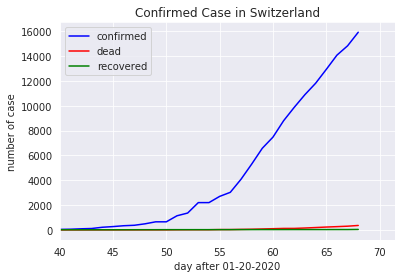

In [72]:
confirmed_swiss=confirmed.iloc[206,4:]
dead_swiss=dead.iloc[206,4:]
recovered_swiss=recovered.iloc[206,4:]
confirmed_swiss
time=np.arange(len(confirmed_swiss))
plt.figure()
plt.title('Confirmed Case in Switzerland')
plt.xlabel('day after 01-20-2020')
plt.ylabel('number of case')
plt.plot(time,confirmed_swiss,'b-',label='confirmed')
plt.plot(time,dead_swiss,'r-',label='dead')
plt.plot(time,recovered_swiss,'g-',label='recovered')
plt.legend()
plt.xlim(40)
plt.show()